<h1>Download and Load Data</h1>

In [1]:
from scripts.data_fetch import fetch_data, load_data
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from zlib import crc32
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("./DATASETS")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

data = {'data_path': HOUSING_PATH, 'data_url': HOUSING_URL, 'data_file_name': 'housing.tgz'}
fetch_data(data)
housing_csv = load_data(HOUSING_PATH, 'housing.csv')
housing_csv.head()

data_fetch done...


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<h1> Pre-processing data </h1>

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64
income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64


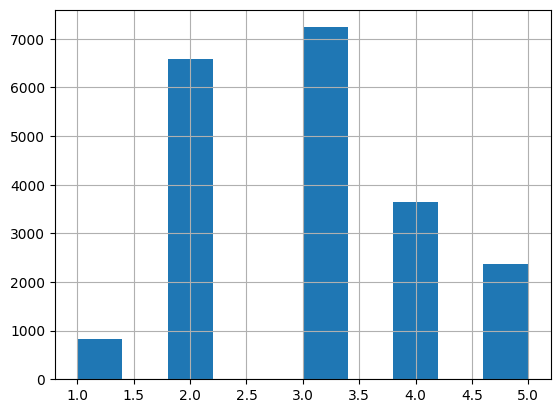

In [2]:
def split_train_test(data, test_ratio):
    '''useful but not allow reproductible data.Generated train data cannot be the same in other training'''
    shuffle_indices = np.random.permutation(len(data))
    test_indices_size = int(len(data) * test_ratio)
    test_indices = shuffle_indices[:test_indices_size]
    train_indices = shuffle_indices[test_indices_size:]
    return data.iloc[train_indices] , data.iloc[test_indices]

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    '''useful for data seed . '''
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_ : test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]
    
housing_with_id = housing_csv.reset_index()
train_data , test_data = split_train_test_by_id(housing_with_id, 0.2, 'index')

housing_csv["income_cat"] = pd.cut(housing_csv["median_income"],
                                   bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                   labels=[1, 2, 3, 4, 5]
                                  )
housing_csv["income_cat"].hist()

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index , test_index in split.split(housing_csv, housing_csv['income_cat']):
    strat_train_set = housing_csv.loc[train_index]
    strat_test_set = housing_csv.loc[test_index]
    
    
print(strat_test_set['income_cat'].value_counts()/len(strat_test_set))
print(housing_csv['income_cat'].value_counts()/len(housing_csv))

for _set in (strat_train_set , strat_test_set):
    _set.drop('income_cat', axis=1 , inplace=True)

In [ ]:
housing_full_data = strat_train_set.copy()
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

housing_full_data.plot(kind='scatter' , 
             x='longitude', 
             y='latitude' , 
             alpha = 0.4 , 
             s=housing['population']/100,
             c = 'median_house_value',
             cmap = plt.get_cmap('jet'),
             colorbar = True,
             label ='population')
plt.legend()

In [ ]:
housing.corr()

In [ ]:
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median, inplace=True)

inputer = SimpleImputer(strategy='median')
housing_num = housing.drop('ocean_proximity', axis=1)
inputer.fit(housing_num)
print(inputer.statistics_)
print(housing_num.median().values)

In [ ]:
housing_cat = housing[['ocean_proximity']]
housing_cat[:10]
hot_encoder = OneHotEncoder()
cat_encoder = hot_encoder.fit_transform(housing_cat)
cat_encoder.toarray()

class CombinedTransform(BaseEstimator , TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_ix , bedrooms_ix , population_ix, households_ix = 3,4,5,6
        rooms_per_households = X[:, rooms_ix] / X[:, households_ix] 
        population_per_households = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room :
            bedrooms_per_room = X[:,bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X,rooms_per_households , population_per_households, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_households , population_per_households]

In [ ]:
from sklearn.linear_model import LinearRegression , SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

#performing learning by LinearRgression , DecisionTreeRegression and SGDRegressor(Gradient Based Regression) 

num_pipeline = Pipeline([
('imputer_ext', SimpleImputer(strategy='median')),
('attr_adder', CombinedTransform()),
('attr_scaler', StandardScaler())
])

housing_pipeline = num_pipeline.fit_transform(housing_num)

list_num = list(housing_num)
housing_cats = ['ocean_proximity']

perform_pipeline_column = ColumnTransformer([
('num', num_pipeline, list_num),
('cat', OneHotEncoder(), housing_cats)
])

class RegressionBasedType:
    
    ln_model = None
    
    def __init__(self, regression_type, data_train, data_train_labels, data_test, data_test_labels):
        self.regression_type = regression_type #must be a class
        self.data_train = data_train
        self.data_train_labels = data_train_labels
        self.data_test = data_test
        self.data_test_labels = data_test_labels
        
        
    def train(self):
        self.ln_model = self.regression_type()
        self.ln_model.fit(self.data_train, self.data_train_labels)
        return self
        
    def test_return(self):
        #data_test must be perform by ColumnTransformer pipeline and not contains y label
        predicted_data = self.ln_model.predict(self.data_test)
        return predicted_data , self.data_test_labels
    
    def metrics_error(self):
        #performance measure used is root mean squrared error
        predicted_data , data_labels = self.test_return()
        mse = mean_squared_error(data_labels, predicted_data)
        rmse = np.sqrt(mse)
        return rmse
        
housing_prepared = perform_pipeline_column.fit_transform(housing)
some_data_prepared = perform_pipeline_column.transform(housing.iloc[:5]) #use for test so not fit
some_data_labels = housing_labels.iloc[:5] #use for test label

LinearReg = RegressionBasedType(
    regression_type=LinearRegression, 
    data_train=housing_prepared, 
    data_train_labels = housing_labels,
    data_test=some_data_prepared,
    data_test_labels = some_data_labels
)

DecisionTreeReg = RegressionBasedType(
    regression_type=DecisionTreeRegressor, 
    data_train=housing_prepared, 
    data_train_labels = housing_labels,
    data_test=some_data_prepared,
    data_test_labels = some_data_labels
)

SGDReg = RegressionBasedType(
    regression_type=SGDRegressor, 
    data_train=housing_prepared, 
    data_train_labels = housing_labels,
    data_test=some_data_prepared,
    data_test_labels = some_data_labels
)


LinearReg.train()
DecisionTreeReg.train()
SGDReg.train()
linear_metrics_error = LinearReg.metrics_error()
decision_metrics_error = DecisionTreeReg.metrics_error()
sgd_metrics_error = SGDReg.metrics_error()
print(linear_metrics_error)
print(decision_metrics_error)
print(sgd_metrics_error)

<h1>Wow, is this mean that DecisionTree Regression performs so good the learning ? Let's try cross validation &#128515;</h1> 

In [ ]:
from sklearn.model_selection import cross_val_score
linear_regression = LinearRegression()
decision_tree = DecisionTreeRegressor()

score1 = cross_val_score(
    linear_regression, 
    housing_prepared, 
    housing_labels, 
    scoring='neg_mean_squared_error', 
    cv=10)

score2 = cross_val_score(
    decision_tree,
    housing_prepared,
    housing_labels,
    scoring = 'neg_mean_squared_error',
    cv = 10
    )

linear_squared_error = np.sqrt(-score1)
tree_squared_error = np.sqrt(-score2)
print('======>For Linear Regression')
print(linear_squared_error.mean())
print(linear_squared_error.std())
print('=======> For Decision Tree Regression')
print(tree_squared_error.mean())
print(tree_squared_error.std())

<h1>Probally not. It performs so good the learning that we don't worry about overfiting &#128515;</h1>